## SHAP -- SHapley Additive exPlanations

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy
from matplotlib import colors

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'nbc': ['nan'],
    'neg': ['0', '0.0'],
    'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'nbc'}}},
 'txp': {'input': True,
  'src_names': ['Confirmed Txp'],
  'label': 'Transplant recipient',
  'unique_per_sbj': True,
  'factor': {'levels': {'no': ['0', '0.0', 'nan'], 'yes': ['1', '1.0']},
   

In [4]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1440 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


In [5]:
# # Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
# bsi_stream.engineer.BuildMVTS(csv_pool_path, 
#                               #nsbj = 6000, # number of subjects / patients to sample from the pool 
#                               nsbj = 60, # number of subjects / patients to sample from the pool 
#                               replace=True, # sample with replacement or not 
#                               valid_frac = 0.2, # fraction of number of subjects in validation dataset
#                               test_frac = 0, # fraction of number of subjects in left-out test dataset
#                               batch_size = 64, # batch size (usually 32,64,128..)
#                               impute_input='median', # imputation on predictors
#                               impute_output='median' )# imputation on response (no need in BSI project)

# # please see the end of console 
# # # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [6]:
# bsi_stream.engineer.info()

In [7]:
# # save raw dataframe in a csv
# bsi_stream.engineer.train_df.to_csv("./train_df.csv", index=False)
# bsi_stream.engineer.valid_df.to_csv("./valid_df.csv", index=False)
# bsi_stream.engineer.train_df_imputed.to_csv("./train_df_median.csv", index=False)
# bsi_stream.engineer.valid_df_imputed.to_csv("./valid_df_median.csv", index=False)

## Model -- scale inputs by percentile

In [8]:
# input and output variable name lists
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital'] # 'systolic_blood_pressure___vital',
output_var = ['y___pos']

# read datasets
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)
whole_df.reset_index(drop=True,inplace=True)

# percentile of inputs
whole_df[input_vars] = whole_df[input_vars].rank(pct=True)


In [9]:
train_df = whole_df.loc[range(train_df.shape[0]),:].copy()
valid_df = whole_df.loc[range(train_df.shape[0], whole_df.shape[0]),:].copy()

# select modeling time window
train_df = train_df.loc[(train_df['__ep_relative_time']/60>=-24) & (train_df['__ep_relative_time']/60<=0) ,:]
valid_df = valid_df.loc[(valid_df['__ep_relative_time']/60>=-24) & (valid_df['__ep_relative_time']/60<=0) ,:]


# median imputation
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(train_df.median(), inplace=True)


# combine to one dataframe
whole_df = pd.concat([train_df, valid_df], axis=0)

In [11]:
# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,25,31) )
Y_whole = np.reshape(Y_whole, (-1,25,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,25,31) )
Y_train = np.reshape(Y_train, (-1,25,1) )[:,0,:]
print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,25,31) )
Y_valid = np.reshape(Y_valid, (-1,25,1) )[:,0,:]
print(X_valid.shape)
print(Y_valid.shape)

# # add fake postive and negative cases
# fake_pos = np.mean(X_whole[Y_whole[:,0]==1,:,:],axis=0)
# fake_ctrl = np.mean(X_whole[Y_whole[:,0]==0,:,:],axis=0)
# new_cases = np.stack([fake_pos,fake_ctrl])
# X_valid = np.append(new_cases, X_valid, axis=0)

(6557, 25, 31)
(6557, 1)
(5226, 25, 31)
(5226, 1)
(1331, 25, 31)
(1331, 1)


### Logistic Regression

In [11]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 801       
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 1s 3ms/step - loss: 0.3950 - AUROC: 0.5730 - AUPRC: 0.1692 - val_loss: 0.3778 - val_AUROC: 0.7211 - val_AUPRC: 0.3165
Epoch 2/50
164/164 [==============================] - 0s 1ms/step - loss: 0.3555 - AUROC: 0.7488 - AUPRC: 0.3575 - val_loss: 0.3741 - val_AUROC: 0.7500 - val_AUPRC: 0.3451
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: 0.3415 - AUROC: 0.7645 - AUPRC: 0.3653 - val_loss: 0.3503 - val_AUROC: 0.7655 - val_AUPRC: 0.3634
Epoc

### LSTM

In [12]:
# myMetrics = [
#     keras.metrics.AUC(name='AUROC', curve='ROC'),
#     keras.metrics.AUC(name='AUPRC', curve='PR')
# ]

# keras.backend.clear_session()
# mdl = keras.models.Sequential([
#     keras.Input(shape=list(X_train.shape)[1:4]),
#     keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2),
#     keras.layers.Dense(1, activation='sigmoid')
# ])
# mdl.summary()
# mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
# callback = EarlyStopping(monitor='val_loss', patience=10)
# his = mdl.fit(X_train, Y_train, 
#               epochs=50, 
#               validation_data=(X_valid,Y_valid), callbacks=[callback])
# keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
# his = mdl.fit(X_train, Y_train, 
#               epochs=50, 
#               validation_data=(X_valid,Y_valid), callbacks=[callback])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,153
Trainable params: 3,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
164/164 [==============================] - 5s 19ms/step - loss: 0.4048 - AUROC: 0.5698 - AUPRC: 0.1573 - val_loss: 0.3830 - val_AUROC: 0.7134 - val_AUPRC: 0.2600
Epoch 2/50
164/164 [==============================] - 3s 17ms/step - loss: 0.3628 - AUROC: 0.7149 - AUPRC: 0.2772 - val_loss: 0.3836 - val_AUROC: 0.7392 - val_AUPRC: 0.3051
Epoch 3/50
164/164 [==============================] - 3s 17ms/step - loss: 0.3577 - AUROC: 0.7351 - AUPRC: 0.2880 - val_loss: 0.3581 - val_AUROC: 0.7485 - val_AUPRC: 0.33

Epoch 7/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2713 - AUROC: 0.8650 - AUPRC: 0.5590 - val_loss: 0.3322 - val_AUROC: 0.8185 - val_AUPRC: 0.4412
Epoch 8/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2704 - AUROC: 0.8651 - AUPRC: 0.5602 - val_loss: 0.3313 - val_AUROC: 0.8193 - val_AUPRC: 0.4438
Epoch 9/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2722 - AUROC: 0.8611 - AUPRC: 0.5632 - val_loss: 0.3324 - val_AUROC: 0.8186 - val_AUPRC: 0.4406
Epoch 10/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2697 - AUROC: 0.8668 - AUPRC: 0.5629 - val_loss: 0.3307 - val_AUROC: 0.8195 - val_AUPRC: 0.4389
Epoch 11/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2677 - AUROC: 0.8665 - AUPRC: 0.5739 - val_loss: 0.3396 - val_AUROC: 0.8161 - val_AUPRC: 0.4403
Epoch 12/50
164/164 [==============================] - 3s 17ms/step - loss: 0.2689 - AUROC: 0.8660 - AUPRC: 0.5652 - val_loss: 0.3376

In [14]:
import shap

# add fake postive and negative cases
fake_pos = np.mean(X_whole[Y_whole[:,0]==1,:,:],axis=0)
fake_ctrl = np.mean(X_whole[Y_whole[:,0]==0,:,:],axis=0)
new_cases = np.stack([fake_pos,fake_ctrl])
X_valid = np.append(new_cases, X_valid, axis=0)

explainer = shap.DeepExplainer(mdl, X_train)
values = explainer.shap_values(X_valid)

You have provided over 5k background samples! For better performance consider using smaller random sample.


In [15]:
input_vars = ['txp', 'age', 'temperature', 'heart_rate', 'resp_rate', 'spo2', 'x_hr_rr', 's_hr', 's_rr', 
              's_so2', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose', 'bilirubin', 
              'potassium', 'albumin', 'calcium', 'sodium', 'wbc', 'phosphorus', 'creatinine', 'platelet_count',
              'alt', 'alp', 'ast', 'pco2', 'chloride', 'troponin', 'ptt', 'lactate', 'bun', 'magnesium']

# init the JS visualization code
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0].numpy(), values[0][0], X_valid[0], feature_names=input_vars)

In [16]:
input_vars = ['txp', 'age', 'temperature', 'heart_rate', 'resp_rate', 'spo2', 'x_hr_rr', 's_hr', 's_rr', 
              's_so2', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose', 'bilirubin', 
              'potassium', 'albumin', 'calcium', 'sodium', 'wbc', 'phosphorus', 'creatinine', 'platelet_count',
              'alt', 'alp', 'ast', 'pco2', 'chloride', 'troponin', 'ptt', 'lactate', 'bun', 'magnesium']

# init the JS visualization code
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value[0].numpy(), values[0][0], X_valid[1], feature_names=input_vars)

### Prepare dataset

In [12]:
# input and output variable name lists
input_vars = ['txp___yes', 'age___vital', 'temp___vital', 'heart_rate___vital', 'resp_rate___vital', 'spo2___vital', 'x_hr_rr___vital', 's_hr___vital', 's_rr___vital', 's_so2___vital', 'diastolic_blood_pressure___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'sodium___vital', 'wbc___vital', 'phosphorus___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'pco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital'] # 'systolic_blood_pressure___vital', 
output_var = ['y___pos']

# read datasets
train_df = pd.read_csv("./train_df.csv")
valid_df = pd.read_csv("./valid_df.csv")
whole_df = pd.concat([train_df, valid_df], axis=0)
whole_df.reset_index(drop=True,inplace=True)

# percentile of inputs
whole_df[input_vars] = whole_df[input_vars].rank(pct=True)

train_df = whole_df.loc[range(train_df.shape[0]),:].copy()
valid_df = whole_df.loc[range(train_df.shape[0], whole_df.shape[0]),:].copy()

# select modeling time window
train_df = train_df.loc[(train_df['__ep_relative_time']/60>=-24) & (train_df['__ep_relative_time']/60<=0) ,:]
valid_df = valid_df.loc[(valid_df['__ep_relative_time']/60>=-24) & (valid_df['__ep_relative_time']/60<=0) ,:]


# median imputation
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(train_df.median(), inplace=True)

# combine to one dataframe
whole_df = pd.concat([train_df, valid_df], axis=0)

# reformat inputs to be 2d image and 1 output per image
X_whole = whole_df[input_vars].values
Y_whole = whole_df[output_var].values
X_whole = np.reshape(X_whole, (-1,25,31) )
Y_whole = np.reshape(Y_whole, (-1,25,1) )[:,0,:]
print(X_whole.shape)
print(Y_whole.shape)

# reformat inputs to be 2d image and 1 output per image
X_train = train_df[input_vars].values
Y_train = train_df[output_var].values
X_train = np.reshape(X_train, (-1,25,31) )
Y_train = np.reshape(Y_train, (-1,25,1) )[:,0,:]
print(X_train.shape)
print(Y_train.shape)

# reformat inputs to be 2d image and 1 output per image
X_valid = valid_df[input_vars].values
Y_valid = valid_df[output_var].values
X_valid = np.reshape(X_valid, (-1,25,31) )
Y_valid = np.reshape(Y_valid, (-1,25,1) )[:,0,:]
print(X_valid.shape)
print(Y_valid.shape)


(6557, 25, 31)
(6557, 1)
(5226, 25, 31)
(5226, 1)
(1331, 25, 31)
(1331, 1)


### sklearn -- aggregated Logistic Regression

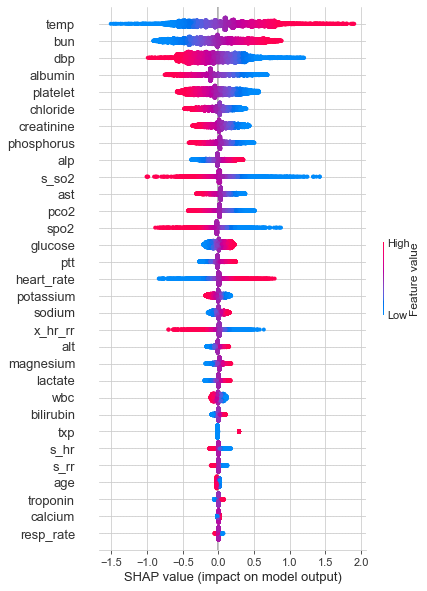

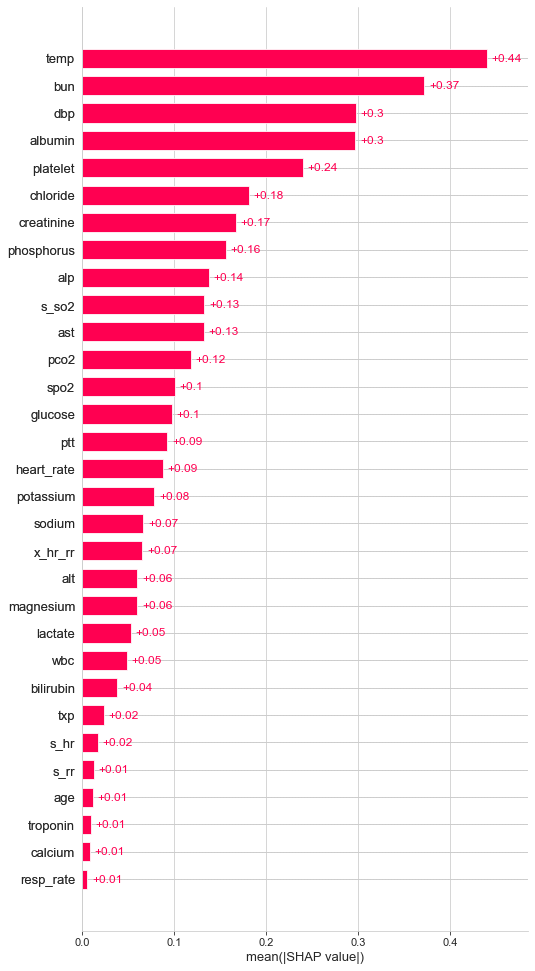

In [14]:
# prepare column names
input_vars = ['txp', 'age', 'temp', 'heart_rate', 'resp_rate', 'spo2', 'x_hr_rr', 's_hr', 's_rr', 
              's_so2', 'dbp', 'glucose', 'bilirubin', 
              'potassium', 'albumin', 'calcium', 'sodium', 'wbc', 'phosphorus', 'creatinine', 'platelet',
              'alt', 'alp', 'ast', 'pco2', 'chloride', 'troponin', 'ptt', 'lactate', 'bun', 'magnesium']#'sbp', 

X_whole_2d = np.mean(X_whole, axis=1)
X_whole_2d = pd.DataFrame(X_whole_2d, columns=input_vars)
Y_whole_2d = Y_whole[:,0]

# add "fake patients" to the first 2 rows in X_whole_2d
pos_row = pd.DataFrame(np.mean(X_whole_2d.loc[Y_whole_2d==1,:], axis=0)).T
neg_row = pd.DataFrame(np.mean(X_whole_2d.loc[Y_whole_2d==0,:], axis=0)).T
X_whole_2d = pd.concat([pos_row, X_whole_2d],axis=0)
X_whole_2d = pd.concat([neg_row, X_whole_2d],axis=0)
X_whole_2d.reset_index(drop=True,inplace=True)

X_train_2d = np.mean(X_train, axis=1)
X_train_2d = pd.DataFrame(X_train_2d, columns=input_vars)
Y_train_2d = Y_train[:,0]

X_valid_2d = np.mean(X_valid, axis=1)
X_valid_2d = pd.DataFrame(X_valid_2d, columns=input_vars)
Y_valid_2d = Y_valid[:,0]

import shap
import sklearn

model = sklearn.linear_model.LogisticRegressionCV(cv=5, random_state=0, penalty="l2")
model.fit(X_train_2d, Y_train_2d)

explainer = shap.Explainer(model, X_whole_2d, feature_names=input_vars)
e = explainer(X_whole_2d)

# summarize the effects (in log odds scale) of all the features
shap.plots.beeswarm(e, max_display=31, plot_size=(6,10))
shap.plots.bar(e, max_display=31)


In [16]:
# init the JS visualization code
shap.initjs()
# positive 
ind = 0
shap.plots.force(e[ind])

In [38]:
# negative
ind = 1
shap.plots.force(e[ind])